<a href="https://colab.research.google.com/github/Pratham1503006/GFG21Days/blob/main/16_Intelligent_Document_Automation_Building_a_Smart_OCR_Bot.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# A Comprehension of Intelligent Document Processing

Intelligent Document Processing (IDP) is an advanced automation technology that transforms the way businesses handle documents. By leveraging artificial intelligence (AI), IDP systems can automatically read, understand, and process vast quantities of documents, extracting crucial data and feeding it into various business workflows. This technology is a significant leap from traditional Optical Character Recognition (OCR) as it not only digitizes text but also comprehends the context and structure of the information within documents.

At its core, IDP is designed to tackle the challenge of processing unstructured and semi-structured data, which make up a large portion of business documents such as invoices, contracts, emails, and forms. By automating the extraction and interpretation of this data, IDP significantly reduces the need for manual data entry, leading to increased efficiency, higher accuracy, and substantial cost savings.

<br><br>

---
<br><br>

### The Inner Workings of Intelligent Document Processing

The power of IDP lies in its sophisticated multi-step process that intelligently handles documents from ingestion to data delivery. This process typically involves several key stages:

**1. Document Ingestion:** The first step involves importing documents from various sources and in multiple formats, including scanned paper documents, PDFs, Word files, and images.

**2. Pre-processing:** To enhance the quality of the input, documents undergo a pre-processing stage. This includes techniques like noise reduction, image enhancement, and deskewing to improve the accuracy of subsequent data extraction.

**3. Document Classification:** Using machine learning algorithms, the IDP system automatically categorizes documents based on their layout and content. This allows the system to differentiate between an invoice, a purchase order, or a legal contract, for instance.

**4. Data Extraction:** This is the core function of IDP. Advanced AI technologies, including Natural Language Processing (NLP) and computer vision, are employed to identify and extract relevant data fields. For example, from an invoice, it can pull out the invoice number, date, vendor name, and line-item details.

**5. Data Validation:** The extracted data is then validated against predefined rules and existing databases to ensure accuracy and consistency. Any exceptions or discrepancies can be flagged for human review in a "human-in-the-loop" process, which also helps to train and improve the AI model over time.

**6. Integration:** Finally, the structured and validated data is seamlessly integrated into downstream business systems such as Enterprise Resource Planning (ERP), Customer Relationship Management (CRM), or other databases, making the information readily available for further processing and analysis.


From **finance departments** automating invoice processing and expense management to **healthcare organizations** streamlining patient record management and claims processing, IDP is proving to be a game-changer. Even  **human resources** can expedite resume screening and employee onboarding. As the technology continues to evolve, its applications are expected to expand even further, solidifying its role as a cornerstone of modern digital transformation.

# Our Approach

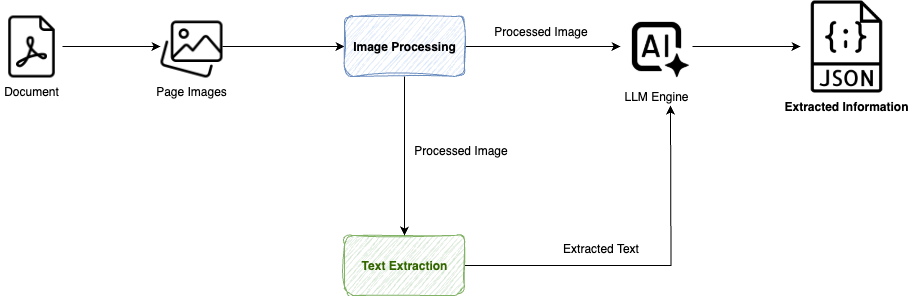

## Understanding the data


The downloaded dataset contains two major folders:
1. **train**: This folder contains the training data.
2. **test**: This folder contains the test data.

Each of these folders contains the following subfolders:
1. **img**: This folder containing the images of the receipts.
2. **box**: This folder containing the bounding box information of the text in the images and the text inside the bounding boxes. The file is a text file with the same name as the image file but with a .txt extension. The format of the file is as follows:
    ```
    x1, y1, x2, y2, x3, y3, x4, y4, text
    ```
    where (x1, y1), (x2, y2), (x3, y3), and (x4, y4) are the coordinates of the bounding box and text is the text inside the bounding box.
3. **entities**: This folder contains the ground truth information of the entities in the receipts. The file is a text file with the same name as the image file but with a .txt extension. The file contains json data with the following format:
    ```json
    {
        "company": "COMPANY_NAME",
        "date": "DATE",
        "address": "ADDRESS",
        "total": "TOTAL",
    }
    ```

## Image Preprocesing: OpenCV

In [14]:
! pip install opencv-python matplotlib numpy

Let's take one image and play with it.

In [16]:
import matplotlib.pyplot as plt
import cv2
import numpy as np

def display_image(image, title="Image"):
    plt.figure(figsize=(7, 7))
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.title(title)
    plt.axis('off')
    plt.show()

### Grayscale Conversion

**Why?** Color information is usually not necessary for reading the text on a receipt. Converting the image to grayscale simplifies it from three color channels (Red, Green, Blue) to a single channel (intensity/brightness). This reduces computational complexity and is a required first step for many subsequent operations like thresholding.

In [26]:
# Convert the image to grayscale
def convert_to_grayscale(image):
  return cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

### Noise (blur) Reduction
**Why?** Scanned images or photos often contain "noise" (random variations in brightness or color). This can look like small specks or graininess, which can confuse OCR algorithms. Applying a slight blur helps to smooth out this noise. A **Gaussian blur** is a common choice as it effectively averages out pixel values with a weighted average, preserving edges better than a simple blur.

In [28]:
def reduce_noise(gray_image):
  return cv2.GaussianBlur(gray_image, (5, 5), 0)

### Binarization (Thresholding)

**Why?** This is one of the most critical steps. Binarization converts the grayscale image into a pure black-and-white image. The goal is to make the text **black** and the background **white**. However, receipts often have uneven lighting or shadows, so a simple (global) threshold won't work well. We use **adaptive thresholding**, which calculates a different threshold for smaller regions of the image, making it robust to lighting changes.

`cv2.adaptiveThreshold()`:

  * `cv2.ADAPTIVE_THRESH_GAUSSIAN_C`: Calculates the threshold for a pixel based on a weighted sum of neighborhood values.
  * `cv2.THRESH_BINARY_INV`: Inverts the result. We want the text to be white pixels (value 255) and the background black (value 0) for the next step (skew correction), which often works by finding white pixel contours.
  * `11`: The size of the neighborhood area (block size).
  * `4`: A constant subtracted from the mean. It's a fine-tuning parameter.

In [29]:
def binarize_image(blur_reduced_image):
  return cv2.adaptiveThreshold(
    blur_reduced_image,
    255,
    cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
    cv2.THRESH_BINARY_INV, # Invert the colors (text becomes white)
    11, # Block size
    4  # Constant C
  )

### Skew Correction

**Why?** Receipts are often scanned or photographed at a slight angle. This skew can significantly reduce the accuracy of OCR. We need to detect this angle and rotate the image to make the text perfectly horizontal.

A common technique is to find the angle of the minimum-area bounding box that encloses all the text (the white pixels in our binarized image) and then rotate the original image by that angle.

In [30]:
def deskew_image(image):
    """
    Corrects the skew of an image by finding the minimum area rectangle
    of the text block and rotating accordingly.
    """
    # Find all non-zero (white) pixels
    coords = cv2.findNonZero(image)

    # Get the minimum area bounding rectangle
    # It returns (center(x,y), (width, height), angle of rotation)
    rect = cv2.minAreaRect(coords)
    angle = rect[-1] - 90

    # The `cv2.minAreaRect` angle has a specific range.
    # We need to adjust it for our rotation.
    if angle < -45:
        angle = -(90 + angle)
    else:
        angle = angle

    # Get the rotation matrix and rotate the image
    (h, w) = image.shape[:2]
    center = (w // 2, h // 2)
    M = cv2.getRotationMatrix2D(center, angle, 1.0)
    rotated = cv2.warpAffine(image, M, (w, h),
                             flags=cv2.INTER_CUBIC,
                             borderMode=cv2.BORDER_REPLICATE)
    print(f"Detected skew angle: {angle:.2f} degrees")

    # Now, rotate the original grayscale image by the same angle
    (h, w) = rotated.shape
    center = (w // 2, h // 2)
    M = cv2.getRotationMatrix2D(center, angle, 1.0)
    deskewed_gray = cv2.warpAffine(rotated, M, (w, h),
                                  flags=cv2.INTER_CUBIC,
                                  borderMode=cv2.BORDER_REPLICATE)

    return deskewed_gray

Let's run the above code for all images

In [31]:
def process_one_image(image):
  image = convert_to_grayscale(image)
  print("Converted image to grayscale..")
  image = reduce_noise(image)
  print("Reduced noise in the image..")
  image = binarize_image(image)
  print("Binarized the image..")
  image = deskew_image(image)
  print("Corrected image orientation..")
  return image

## Text Extraction: Tesseract

Tesseract OCR is a powerful and widely-used open-source optical character recognition (OCR) engine. In simple terms, it's a software that can "read" text from images and convert it into machine-readable text. This means you can take a picture of a document, a sign, or any other object containing text, and Tesseract can extract that text so you can edit, search, or analyze it.

### A Brief History and Development

Originally developed by Hewlett-Packard in the 1980s, Tesseract was later open-sourced in 2005 and has been sponsored by Google since 2006. This has led to significant improvements and made it one of the most accurate and versatile free OCR engines available. The latest versions of Tesseract utilize long short-term memory (LSTM), a type of recurrent neural network (RNN), which has greatly enhanced its ability to recognize text with high accuracy.



### Core Functionalities and Capabilities

Tesseract boasts a rich set of features that make it a flexible tool for various applications:

  * **Extensive Language Support:** Tesseract can recognize over 100 languages, making it a truly global OCR solution. It also supports multiple scripts and can even be trained to recognize new languages.
  * **Multiple Output Formats:** It can output the recognized text in various formats, including plain text, HTML, PDF, and TSV (tab-separated values). This allows for easy integration with other software and workflows.
  * **Page Segmentation Modes:** Tesseract offers different page segmentation modes, which help in correctly identifying the layout of a document, including columns, paragraphs, and blocks of text.
  * **Character Recognition and Confidence:** Not only does it recognize characters, but it can also provide a confidence score for each recognized character, word, or line. This is useful for assessing the accuracy of the OCR process.
  * **Command-Line and API Access:** Tesseract can be used as a command-line tool for quick and simple OCR tasks. For more complex integrations, it provides an API that allows developers to incorporate its OCR capabilities into their own applications. Popular wrappers like Pytesseract make it easy to use Tesseract with programming languages like Python.


### Installation
`pip install pytesseract pillow`


### How to Use Tesseract

For developers, integrating Tesseract into an application is straightforward using its API. Here is a simple example using the `pytesseract` wrapper in Python:

```python

from PIL import Image
import pytesseract


text = pytesseract.image_to_string(Image.open(filename))

print(text)
```



### Common Use Cases and Applications

The ability to extract text from images opens up a vast range of applications across various industries:

  * **Document Digitization:** Converting scanned documents, books, and historical archives into searchable digital text.
  * **Data Entry Automation:** Automating the process of entering data from invoices, receipts, and forms.
  * **Accessibility:** Assisting visually impaired individuals by converting printed text into speech.
  * **License Plate Recognition:** In law enforcement and traffic management systems.
  * **Social Media Monitoring:** Analyzing text within images shared on social media platforms.
  * **Translation:** Extracting text from an image and then using a translation service to translate it.

While Tesseract is a powerful tool, the accuracy of its output heavily depends on the quality of the input image. For best results, images should be clear, well-lit, and have a high resolution. Pre-processing steps like resizing, noise reduction, and converting to grayscale can significantly improve OCR accuracy.

In [13]:
! pip install pytesseract pillow

## Information Extraction

Can we improve the prompt using the [Unified Framework For An Effective Prompt](https://www.geeksforgeeks.org/data-science/a-unified-framework-for-an-effective-prompt/)?

In [33]:
from google import genai
from google.colab import userdata # colab only code
from PIL import Image
import json
import time

In [34]:
genai_client = genai.Client(api_key=userdata.get('GOOGLE_API_KEY'))

# Can you play with a Resume Dataset?

https://www.kaggle.com/datasets/snehaanbhawal/resume-dataset

In [7]:
import kagglehub
import pandas as pd

# Download latest version
path = kagglehub.dataset_download("snehaanbhawal/resume-dataset")

print("Path to dataset files:", path)

# Load the dataset into a pandas DataFrame
df = pd.read_csv(f'{path}/Resume/Resume.csv')

# Display the first few rows
display(df.head())

Using Colab cache for faster access to the 'resume-dataset' dataset.
Path to dataset files: /kaggle/input/resume-dataset


,ID,Resume_str,Resume_html,Category
0,16852973,HR ADMINISTRATOR/MARKETING ASSOCIATE\...,"<div class=""fontsize fontface vmargins hmargin...",HR
1,22323967,"HR SPECIALIST, US HR OPERATIONS ...","<div class=""fontsize fontface vmargins hmargin...",HR
2,33176873,HR DIRECTOR Summary Over 2...,"<div class=""fontsize fontface vmargins hmargin...",HR
3,27018550,HR SPECIALIST Summary Dedica...,"<div class=""fontsize fontface vmargins hmargin...",HR
4,17812897,HR MANAGER Skill Highlights ...,"<div class=""fontsize fontface vmargins hmargin...",HR


# Task
Convert the `Resume_html` column of the dataset from "https://www.kaggle.com/datasets/snehaanbhawal/resume-dataset" to images.

## Set up rendering environment

### Subtask:
Install necessary libraries for rendering HTML to images (e.g., `imgkit` or `playwright`).


**Reasoning**:
The subtask requires installing the `playwright` library and its browsers. The first step is to install the Python library using pip.



In [8]:
! pip install playwright

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.9/45.9 MB 19.1 MB/s eta 0:00:00


**Reasoning**:
Define a function to save HTML content as an image using playwright.



In [10]:
from playwright.sync_api import sync_playwright

def save_html_as_image(html_content, output_path):
    """
    Saves an HTML string as an image file using Playwright.

    Args:
        html_content: The HTML content as a string.
        output_path: The path where the image file will be saved.
    """
    with sync_playwright() as p:
        browser = p.chromium.launch()
        page = browser.new_page()
        page.set_content(html_content)
        page.screenshot(path=output_path, full_page=True)
        browser.close()

## Apply conversion to dataframe

### Subtask:
Iterate through the `Resume_html` column and apply the conversion function to each HTML entry.


In [12]:
import asyncio
from playwright.async_api import async_playwright
import os
import time

async def save_html_as_image_async(html_content, output_path):
    """
    Saves an HTML string as an image file using Playwright Async API.

    Args:
        html_content: The HTML content as a string.
        output_path: The path where the image file will be saved.
    """
    async with async_playwright() as p:
        browser = await p.chromium.launch()
        page = await browser.new_page()
        await page.set_content(html_content)
        await page.screenshot(path=output_path, full_page=True)
        await browser.close()

output_image_dir = "/content/resume_images"

# Create the output directory if it doesn't exist
if not os.path.exists(output_image_dir):
    os.makedirs(output_image_dir)
    print(f"Created directory: {output_image_dir}")

# Iterate through the DataFrame and save each HTML as an image using asyncio
async def process_resumes():
    for index, row in df.iterrows():
        html_content = row['Resume_html']
        resume_id = row['ID']
        output_path = os.path.join(output_image_dir, f"{resume_id}.png")

        try:
            print(f"Processing resume ID: {resume_id}")
            await save_html_as_image_async(html_content, output_path)
            print(f"Saved image for resume ID: {resume_id} to {output_path}")
            # Add a small delay to avoid overwhelming the system
            await asyncio.sleep(1)
        except Exception as e:
            print(f"Error processing resume ID {resume_id}: {e}")

    print("Finished processing all resumes.")

await process_resumes()

Processing resume ID: 16852973
Saved image for resume ID: 16852973 to /content/resume_images/16852973.png
Processing resume ID: 22323967
Saved image for resume ID: 22323967 to /content/resume_images/22323967.png
Processing resume ID: 33176873
Saved image for resume ID: 33176873 to /content/resume_images/33176873.png
Processing resume ID: 27018550
Saved image for resume ID: 27018550 to /content/resume_images/27018550.png
Processing resume ID: 17812897
Saved image for resume ID: 17812897 to /content/resume_images/17812897.png
Processing resume ID: 11592605
Saved image for resume ID: 11592605 to /content/resume_images/11592605.png
Processing resume ID: 25824789
Saved image for resume ID: 25824789 to /content/resume_images/25824789.png
Processing resume ID: 15375009
Saved image for resume ID: 15375009 to /content/resume_images/15375009.png
Processing resume ID: 11847784
Saved image for resume ID: 11847784 to /content/resume_images/11847784.png
Processing resume ID: 32896934
Saved image for

CancelledError: 

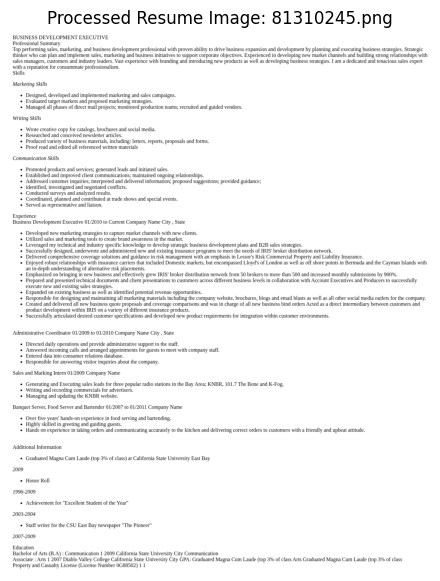

In [25]:
import os
# Assuming the output_image_dir from the previous cell is where the images were saved
output_image_dir = "/content/resume_images"
# Get a list of files in the output directory
image_files = os.listdir(output_image_dir)

# Check if there are any images in the directory
if image_files:
    # Take the first image file found
    one_image_name = image_files[0]
    one_image_path = os.path.join(output_image_dir, one_image_name)

    one_image = cv2.imread(one_image_path)

    if one_image is not None:
        display_image(one_image, f"Processed Resume Image: {one_image_name}")
    else:
        print(f"Error: Unable to load image from {one_image_path}")
else:
    print(f"No images found in the directory: {output_image_dir}")

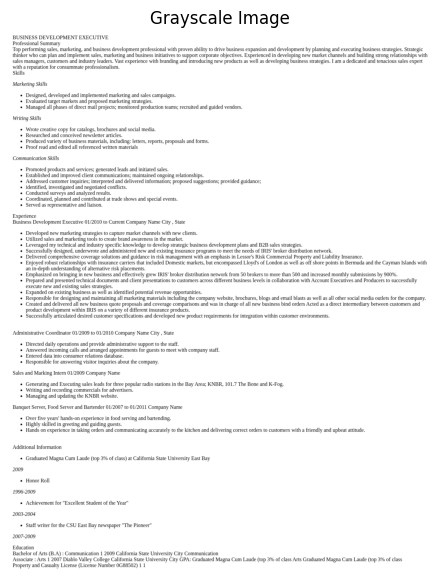

In [27]:
grayscale_image = convert_to_grayscale(one_image)
display_image(grayscale_image, "Grayscale Image")

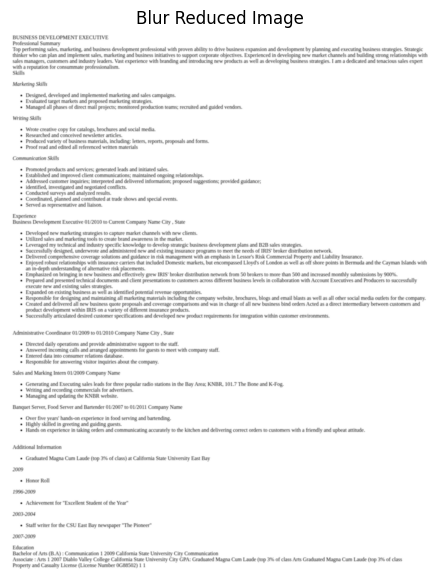

In [35]:
blur_reduced_image = reduce_noise(grayscale_image)
display_image(blur_reduced_image, "Blur Reduced Image")

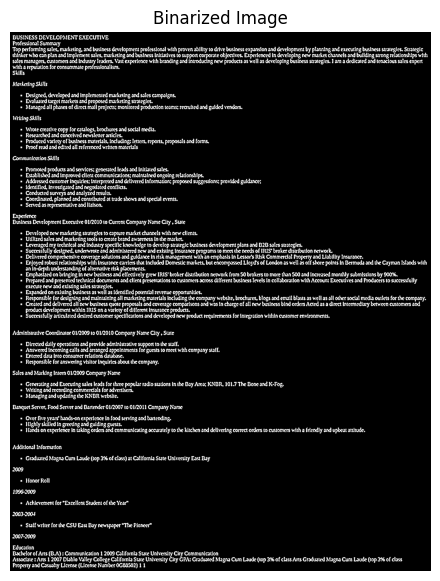

In [36]:
binarized_image = binarize_image(blur_reduced_image)
display_image(binarized_image, "Binarized Image")

In [37]:
deskewed_image = deskew_image(binarized_image)

Detected skew angle: 0.00 degrees


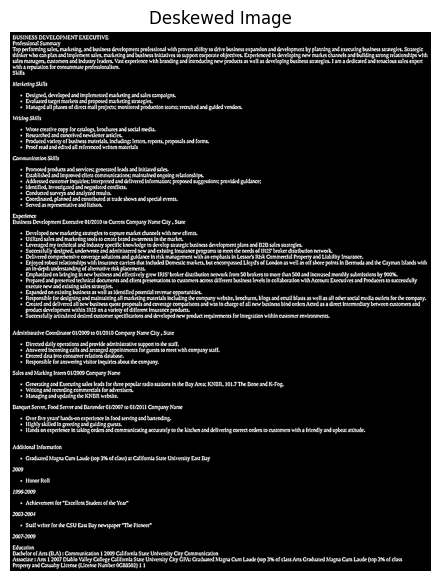

In [38]:
display_image(deskewed_image, "Deskewed Image")

In [39]:
import time
output_folder_path = "/content/processed_resume_images"
input_folder_path = "/content/resume_images"
start_time = time.time()

if os.makedirs(output_folder_path, exist_ok=True):
  print(f"Created folder: {output_folder_path}")

# Process a subset of images to avoid long execution times
for image_name in os.listdir(input_folder_path)[:20]:
  print(f"Processing image: {image_name}")
  image_path = os.path.join(input_folder_path, image_name)
  image = cv2.imread(image_path)

  if image is not None:
      processed_image = process_one_image(image)
      # save image
      output_path = os.path.join(output_folder_path, image_name)
      cv2.imwrite(output_path, processed_image)
      print(f"Saved processed image to: {output_path}")
  else:
      print(f"Error loading image: {image_path}")
  print("-"*50)


print("Processing images is completed.")
print(f"Total time taken: {time.time() - start_time} seconds")

Processing image: 81310245.png
Converted image to grayscale..
Reduced noise in the image..
Binarized the image..
Detected skew angle: 0.00 degrees
Corrected image orientation..
Saved processed image to: /content/processed_resume_images/81310245.png
--------------------------------------------------
Processing image: 52979663.png
Converted image to grayscale..
Reduced noise in the image..
Binarized the image..
Detected skew angle: 0.00 degrees
Corrected image orientation..
Saved processed image to: /content/processed_resume_images/52979663.png
--------------------------------------------------
Processing image: 18316239.png
Converted image to grayscale..
Reduced noise in the image..
Binarized the image..
Detected skew angle: -0.00 degrees
Corrected image orientation..
Saved processed image to: /content/processed_resume_images/18316239.png
--------------------------------------------------
Processing image: 26480367.png
Converted image to grayscale..
Reduced noise in the image..
Binarize

In [40]:
from PIL import Image
import pytesseract

pytesseract.image_to_string(Image.open('/content/processed_resume_images/30968749.png'))

'par Nestle tas\nPe Bad\n\nAn professional with experience In deating with the optimization of complex processes or systems as well as providing stcel framing solutions to residential and commercial applications. Dedicated\nenglocer with excellent technical, analytical and communication skills demonstrated by 4 years of experience.Experienced CAD Drafter with solid knowledge of the practical application of\nenglacering science and technology. Proven ability to manage multiple projects and meet critical deadlines.\n\nBiauty\nPARE si Sat Ciccis g\n\nBSN Roses cre Sour ad Delco\n\nRee Cau rcs n i Cento (oun cag Set eleeg\n= Tralning program implementation\n\nbar ees ni Bos vemiia ced\n\nSoftwareslgorthm design and development | Laboratory evaporators\nCS: Pees\n\ntd aad ME Sei MeN\n\nPa nny Basher acy rs\n\nSart suid\nBurnes ua)\n\nBS Osta lolf crus dee\nSCS BSNS Sg sen Par Kid\n\nPsa Shree Rcd\n\nPeo creed\nStatistical Analysts\n\n= Performed data collection and statistical analysis that

In [42]:
from PIL import Image
import pytesseract
import time

input_folder_path = "/content/processed_resume_images"
output_folder_path = "/content/tesseract_output"
start_time = time.time()

if os.makedirs(output_folder_path, exist_ok=True):
  print(f"Created folder: {output_folder_path}")

total_images = sum(1 for entry in os.scandir(input_folder_path))
print(f"Total images in folder: {total_images}")

for i, image_name in enumerate(os.listdir(input_folder_path)[:20], 1):
  print(f"Processing image {i}/{total_images}: {image_name}")
  image_path = os.path.join(input_folder_path, image_name)
  print("Extracting text from image..")
  text = pytesseract.image_to_string(Image.open(image_path))
  output_path = os.path.join(output_folder_path, image_name.replace(".png", ".txt"))
  with open(output_path, "w") as f:
    f.write(text)

  print(f"Saved extracted text to {output_path}")
  print("-"*50)

print("Text Extraction Completed.")
print(f"Total time taken: {time.time() - start_time} seconds")

Total images in folder: 20
Processing image 1/20: 81310245.png
Extracting text from image..
Saved extracted text to /content/tesseract_output/81310245.txt
--------------------------------------------------
Processing image 2/20: 52979663.png
Extracting text from image..
Saved extracted text to /content/tesseract_output/52979663.txt
--------------------------------------------------
Processing image 3/20: 18316239.png
Extracting text from image..
Saved extracted text to /content/tesseract_output/18316239.txt
--------------------------------------------------
Processing image 4/20: 26480367.png
Extracting text from image..
Saved extracted text to /content/tesseract_output/26480367.txt
--------------------------------------------------
Processing image 5/20: 28974459.png
Extracting text from image..
Saved extracted text to /content/tesseract_output/28974459.txt
--------------------------------------------------
Processing image 6/20: 26780935.png
Extracting text from image..
Saved extract

In [43]:
prompt = """
Extract the following information from the given resume:

- Name: The full name of the job seeker.
- Contact Information: Email address, phone number, and LinkedIn profile (if available).
- Education: Degrees, majors, universities, and graduation dates.
- Work Experience: Company names, job titles, employment dates, and responsibilities/achievements.
- Skills: A list of key skills mentioned in the resume.

Always give your response in the following JSON format:
{
    "Name": "Full Name",
    "Contact Information": {
        "Email": "email@example.com",
        "Phone": "123-456-7890",
        "LinkedIn": "linkedin.com/in/username"
    },
    "Education": [
        {
            "Degree": "Bachelor's",
            "Major": "Computer Science",
            "University": "University Name",
            "Graduation Date": "Year"
        }
    ],
    "Work Experience": [
        {
            "Company": "Company Name",
            "Job Title": "Job Title",
            "Employment Dates": "Start Date - End Date",
            "Responsibilities": ["Responsibility 1", "Responsibility 2"]
        }
    ],
    "Skills": ["Skill 1", "Skill 2", "Skill 3"]
}

The resume image has been preprocessed (grayscale, noise reduced, binarized, and deskewed) using OpenCV, and text has been extracted using Tesseract. Use the extracted text as support for extracting information, but you can correct minor errors if necessary.

Respond with the extracted information only in the specified JSON format.

Here is the extracted text:

"""

In [ ]:
image_folder_path = "/content/processed_resume_images"
text_folder_path = "/content/tesseract_output"
output_folder_path = "/content/json_output"

start_time = time.time()

if os.makedirs(output_folder_path, exist_ok=True):
  print(f"Created folder: {output_folder_path}")

total_images = sum(1 for entry in os.scandir(image_folder_path))
print(f"Total images in folder: {total_images}")

for i, image_name in enumerate(os.listdir(input_folder_path)[:20], 1):
  print(f"Processing image {i}/{total_images}: {image_name}")
  image_path = os.path.join(input_folder_path, image_name)
  print(f"Loading image: {image_path}")
  with open(image_path, "rb") as f:
    image = Image.open(image_path)


  text_path = os.path.join(text_folder_path, image_name.replace(".png", ".txt"))
  print(f"Loading extracted text: {text_path}")
  with open(text_path, "r") as f:
    text = f.read()

  print("Extracting information from image and text..")

  prompt = prompt + text



  contents = [
        image,
        {
            "text": prompt
        }
    ]
  response = genai_client.models.generate_content(model='gemini-1.5-flash', contents=contents)

  # Access the usage_metadata attribute
  usage_metadata = response.usage_metadata

  # Print the different token counts
  print(f"Input Token Count: {usage_metadata.prompt_token_count}")
  print(f"Thoughts Token Count: {response.usage_metadata.thoughts_token_count}")
  print(f"Output Token Count: {usage_metadata.candidates_token_count}")
  print(f"Total Token Count: {usage_metadata.total_token_count}")

  extracted_information = json.loads(response.text.replace('```json', '').replace('```', ''))
  output_path = os.path.join(output_folder_path, image_name.replace(".png", ".json"))
  with open(output_path, "w") as f:
    json.dump(extracted_information, f, indent=4)

  print(f"Saved extracted information to {output_path}")
  print("-"*50)
  time.sleep(60)

print("Information Extraction Completed.")
print(f"Total time taken: {time.time() - start_time} seconds")

Total images in folder: 20
Processing image 1/20: 81310245.png
Loading image: /content/processed_resume_images/81310245.png
Loading extracted text: /content/tesseract_output/81310245.txt
Extracting information from image and text..
Input Token Count: 2860
Thoughts Token Count: None
Output Token Count: 1106
Total Token Count: 3966
Saved extracted information to /content/json_output/81310245.json
--------------------------------------------------
Processing image 2/20: 52979663.png
Loading image: /content/processed_resume_images/52979663.png
Loading extracted text: /content/tesseract_output/52979663.txt
Extracting information from image and text..
Input Token Count: 4026
Thoughts Token Count: None
Output Token Count: 1577
Total Token Count: 5603
Saved extracted information to /content/json_output/52979663.json
--------------------------------------------------
Processing image 3/20: 18316239.png
Loading image: /content/processed_resume_images/18316239.png
Loading extracted text: /content